<a href="https://colab.research.google.com/github/VJalili/temp_test_notebook/blob/test/PZM_Parse_VCF_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup gsutil and AuthNZ

In [ ]:
# !gcloud init

In [ ]:
from subprocess import check_output
def object_exists(bucket):
  out = check_output(f"gsutil -q stat {bucket}; echo $?", shell=True).decode("utf-8").strip()
  return True if out == "0" else False

def move_object(source, dest):
  out = check_output(f"gsutil -m mv {source} {dest}", shell=True).decode("utf-8").strip()
  return out

def copy_object(source, dest):
  out = check_output(f"gsutil -m cp {source} {dest}", shell=True).decode("utf-8").strip()
  return out

### TEST BLOCK
this is test

In [ ]:
!pip install test
import test_package

### Setup Google Storage Client

In [ ]:
# !gcloud auth application-default login

In [ ]:
from google.cloud import storage
storage_client = storage.Client(project="broad-dsde-methods")

# This method uses the Google cloud storage library which performs faster
# calling gsutil using `check_output`.
def copy_object_to_bucket(bucket_name, blob_name, source_filename):
  bucket = storage_client.get_bucket(bucket_name)
  blob = bucket.blob(blob_name)
  blob.upload_from_filename(source_filename)

In [ ]:
# !pip install pysam

### Import python packages

In [ ]:
import subprocess
import gspread
import copy
from oauth2client.client import GoogleCredentials
import json
import pandas as pd
from pathlib import Path
from dataclasses import dataclass, field
from datetime import datetime
import textwrap
from matplotlib.pyplot import figure
import gzip
from dataclasses import dataclass
from typing import Callable, Any, Dict, Tuple
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import pandas as pd
from matplotlib import pyplot
import os
from os import listdir
import os.path
from os.path import isfile, join
from pathlib import Path
from numpy.lib.function_base import average
import pysam
from pysam import VariantFile
import tensorflow as tf
import base64
from urllib.parse import urljoin
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from typing import Callable
import matplotlib.pyplot as plt
from matplotlib import collections
from sklearn.metrics import confusion_matrix

from dataclasses import dataclass

from tqdm import tqdm
import tqdm.notebook as tq

# import upsetplot
# from upsetplot import plot
import math

import matplotlib.pyplot as plt
import seaborn as sns
custom_style = {"axes.facecolor": "#EAEAF2"}
sns.set_style(rc=custom_style)
sns.color_palette("Set2")

plt.rcParams["axes.facecolor"]="#ffffff"
plt.rcParams["savefig.facecolor"]="#ffffff"

In [ ]:
run_test = True #@param {type:"boolean"}

## Helper methods

In [ ]:
working_dir = os.path.join(".", "pzm")

In [ ]:
# Get and read the data table.
gs_bucket = "gs://broad-dsde-methods-vj/pzm/"
data_table_filename = os.path.join(working_dir, "data_table.tsv")
if not isfile(data_table_filename):
  copy_object(gs_bucket + "data_table.tsv", data_table_filename)

data_table = pd.read_csv(data_table_filename, sep="\t")

sample_id_h = "sample_id" # sample id column header
data_table = data_table.rename(columns={"entity:sample_id": sample_id_h})

In [ ]:
data_table.shape

(1951, 61)

In [ ]:
data_table.head()

,sample_id,RM_sites,RM_summary,WES_ID,WES_call_idx,WES_call_vcf,WES_eval_idx,WES_eval_vcf,analyte_type,anno_rm_gc_pass_vcf,...,original_cram_index,participant,participant_id,read_orientation_model_params,relation,sequencing_assay,sequencing_id,sex,submitter_id,wes_id
0,SS0012986,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,NaN,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,DNA,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,...,gs://fc-secure-22693da1-7a53-4115-9b93-98856c7...,13867.s2,13867.s2,NaN,sibling,WGS,SS0012986.final.cram,Male,NYGC,.
1,SS0012989,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,NaN,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,DNA,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,...,gs://fc-secure-22693da1-7a53-4115-9b93-98856c7...,NaN,13521.s1,NaN,sibling,WGS,SS0012989.final.cram,Female,NYGC,NaN
2,SS0012999,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,12163.p1,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,DNA,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,...,gs://fc-secure-22693da1-7a53-4115-9b93-98856c7...,NaN,12163.p1,NaN,proband,WGS,SS0012999.final.cram,Male,NYGC,NaN
3,SS0013012,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,NaN,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,DNA,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,...,gs://fc-secure-22693da1-7a53-4115-9b93-98856c7...,11420.s1,11420.s1,NaN,sibling,WGS,SS0013012.final.cram,Female,NYGC,NaN
4,SS0013013,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,13332.p1,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,DNA,gs://fc-0e8b9bf4-7749-4228-9bd5-4cdb2b81d3b3/s...,...,gs://fc-secure-22693da1-7a53-4115-9b93-98856c7...,NaN,13332.p1,NaN,proband,WGS,SS0013013.final.cram,Male,NYGC,NaN


In [ ]:
data_table.columns

Index(['sample_id', 'RM_sites', 'RM_summary', 'WES_ID', 'WES_call_idx',
       'WES_call_vcf', 'WES_eval_idx', 'WES_eval_vcf', 'analyte_type',
       'anno_rm_gc_pass_vcf', 'anno_rm_gc_pass_vcf_idx', 'anno_rm_gc_vcf',
       'anno_rm_gc_vcf_idx', 'bamout', 'bamout_i', 'bamout_index',
       'confirmed_wes_wgs_rel', 'contamination_table', 'family_id',
       'father_id', 'filtered_vcf', 'filtered_vcf_idx', 'filtered_zip_vcf',
       'filtered_zip_vcf_idx', 'filtering_stats', 'full_anno_pass_vcf',
       'full_anno_pass_vcf_idx', 'full_anno_vcf', 'full_anno_vcf_idx',
       'funcotated_file', 'funcotated_file_index', 'maf_segments',
       'mod_filtered_vcf', 'mod_filtered_vcf_idx', 'mother_id',
       'mutect_WES_call', 'mutect_WES_eval', 'mutect_sites',
       'mutect_sites_no_SR_SD', 'mutect_sites_no_repeat', 'mutect_stats',
       'mutect_summary', 'mutect_summary_WES_call', 'mutect_summary_WES_eval',
       'mutect_summary_no_SR_SD', 'mutect_summary_no_repeat', 'no_SR_SD_vcf',
     

In [ ]:
def localize_obj_if_needed(sample_id):
  local_filename = os.path.join(working_dir, f"{sample_id}.vcf.gz")
  if not isfile(local_filename):
    copy_object(data_table_dict[sample_id], local_filename)

  unfiltered_local_filename = os.path.join(working_dir, f"unfiltered_{sample_id}.vcf.gz")
  if not isfile(unfiltered_local_filename):
    copy_object(unfiltered_data_table_dict[sample_id], unfiltered_local_filename)

  unfiltered_idx_local_filename = os.path.join(working_dir, f"unfiltered_{sample_id}.vcf.gz.tbi")
  if not isfile(unfiltered_idx_local_filename):
    copy_object(unfiltered_idx_table_dict[sample_id], unfiltered_idx_local_filename)

  return local_filename, unfiltered_local_filename

In [ ]:
vcf_column = "full_anno_pass_vcf" # "anno_rm_gc_pass_vcf"
unfiltered_vcf_column = "full_anno_vcf" # "anno_rm_gc_vcf"
data_table_dict = dict(zip(data_table[sample_id_h], data_table[vcf_column]))
unfiltered_data_table_dict = dict(zip(data_table[sample_id_h], data_table[unfiltered_vcf_column]))
unfiltered_idx_table_dict = dict(zip(data_table[sample_id_h], data_table[unfiltered_vcf_column + "_idx"]))
# sample_ids = ["SS0012986", "SS0012989", "SSC09045", "SSC05448", "SSC02667", "SSC06504", "SSC09053", "SSC04423"]
sample_ids = list(data_table_dict.keys())
# samples = {}
# unfiltered_samples = {}

# for sample_id in sample_ids:
#   local_filename, local_unfiltered_filename = localize_obj_if_needed(sample_id)
#   sample_ids[sample_id] = local_filename
#   unfiltered_samples[sample_id] = local_unfiltered_filename

print(f"Localized files selected from the `{vcf_column}` column in the Terra data table:")
# print(json.dumps(samples, indent=2))

Localized files selected from the `full_anno_pass_vcf` column in the Terra data table:


In [ ]:
# TEST
if run_test:
  _test_sample_id = "SSC04202" #"SSC02602" #"SSC02806"#"SSC06504"
  _test_vcf_filename, _test_unfiltered_vcf_filename = localize_obj_if_needed(_test_sample_id)
  print(_test_vcf_filename)

./pzm/SSC04202.vcf.gz


### Explore molecularly validated variants

In [ ]:
## Localize data from a GS bucket
validation_results_filename = os.path.join(working_dir, "validation_results.txt")

if not isfile(validation_results_filename):
  copy_object("gs://broad-dsde-methods-vj/mutec2-elise/Mutect_validation_results_20230227.txt", validation_results_filename)

molecularly_val_df = pd.read_csv(validation_results_filename, sep="\t")
print(molecularly_val_df.shape)
molecularly_val_df.head()

(1635, 38)


,family_id,participant_id,chr,hg38_pos,ref,alt,ANY_PUB,DOU_RESOLUTION,LIM_RESOLUTION,FREED_RESOLUTION,...,lim_blood_tpcr_vaf,freed_pyro_vaf,krupp_exome_vaf,krupp_wb_vaf,krupp_lcl_vaf,dou_exome_vaf,dou_pasm_maf,WES_vaf_count,WES_vaf,WES_vaf_source
0,11000,11000.p1,13,101237830,G,A,germline,germline,germline,NaN,...,NaN,NaN,NaN,NaN,NaN,0.324324,0.392,2,0.306667,lim_exome_vaf
1,11003,11003.p1,7,77942799,G,A,mosaic,mosaic,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.076087,0.079,1,0.076087,dou_exome_vaf
2,11003,11003.s1,12,56254338,C,A,mosaic,mosaic,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.327869,0.257,1,0.327869,dou_exome_vaf
3,11008,11008.p1,14,65629547,C,T,mosaic,mosaic,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.055556,0.071,1,0.055556,dou_exome_vaf
4,11008,11008.s1,16,16136537,G,A,mosaic,mosaic,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.193548,0.228,1,0.193548,dou_exome_vaf


In [ ]:
molecularly_val_df.columns

Index(['family_id', 'participant_id', 'chr', 'hg38_pos', 'ref', 'alt',
       'ANY_PUB', 'DOU_RESOLUTION', 'LIM_RESOLUTION', 'FREED_RESOLUTION',
       'OROAK_RESOLUTION', 'relation', 'WES_ID', 'confirmed_wes_wgs_rel',
       'WGS_id', 'filtered_zip_vcf', 'funcotate_vcf', 'cram', 'cram_index',
       'WGS_IGV_cram', 'pos', 'Mutect_file', 'Mutect_AD', 'Mutect_VAF',
       'lim_exome_vaf', 'lim_topo_vaf', 'lim_pyro_vaf', 'lim_cell_tpcr_vaf',
       'lim_blood_tpcr_vaf', 'freed_pyro_vaf', 'krupp_exome_vaf',
       'krupp_wb_vaf', 'krupp_lcl_vaf', 'dou_exome_vaf', 'dou_pasm_maf',
       'WES_vaf_count', 'WES_vaf', 'WES_vaf_source'],
      dtype='object')

In [ ]:
# Count per-sample loci and sort
count_mol_val_df = molecularly_val_df.groupby("WGS_id")["WGS_id"].count().reset_index(name="count").sort_values(["count"], ascending=False)
print(count_mol_val_df)

       WGS_id  count
427  SSC09045     39
261  SSC05448     33
99   SSC02667     26
428  SSC09053     25
201  SSC04423     24
..        ...    ...
171  SSC03905      1
366  SSC07615      1
365  SSC07605      1
364  SSC07604      1
312  SSC06504      1

[625 rows x 2 columns]


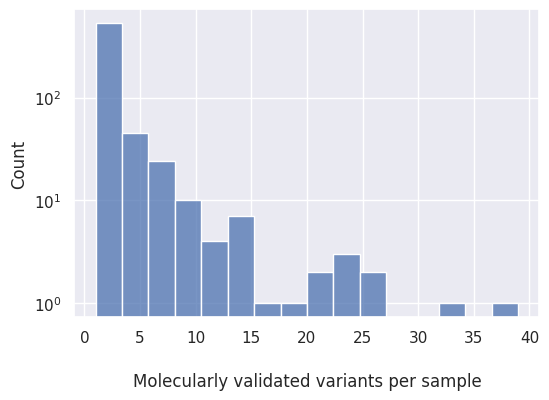

In [ ]:
# Plot the counts.
sns.set()
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=count_mol_val_df["count"], ax=ax, kde=False, bins=16)

plt.xlabel("\nMolecularly validated variants per sample")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

In [ ]:
# Generate a base64 encoding of variant identifier fields in order to better match variants across samples.
def get_var_base64_encoding_row(row):
  return get_var_base64_encoding(row["chr"], row["hg38_pos"], row["ref"], (row["alt"],))

def get_var_base64_encoding(chrom: str, pos: int, ref: str, alts: Tuple[str, ...]) -> str:
  id_phrase = "_".join([chrom.lower().replace("chr", ""), str(pos), ref, *[x for x in alts]])
  b64encode = base64.b64encode(id_phrase.encode("utf-8")).decode("utf-8")
  return b64encode

In [ ]:
b64encode_col = "b64encode"
mol_val_subset_df = molecularly_val_df.loc[:, ["chr", "hg38_pos", "ref", "alt", "ANY_PUB", "WES_vaf", "WGS_id"]].copy()
mol_val_subset_df[b64encode_col] = mol_val_subset_df.apply(get_var_base64_encoding_row, axis=1)

In [ ]:
mol_val_subset_df.head()

,chr,hg38_pos,ref,alt,ANY_PUB,WES_vaf,WGS_id,b64encode
0,13,101237830,G,A,germline,0.306667,SSC02254,MTNfMTAxMjM3ODMwX0dfQQ==
1,7,77942799,G,A,mosaic,0.076087,SSC02497,N183Nzk0Mjc5OV9HX0E=
2,12,56254338,C,A,mosaic,0.327869,SSC02518,MTJfNTYyNTQzMzhfQ19B
3,14,65629547,C,T,mosaic,0.055556,SSC00936,MTRfNjU2Mjk1NDdfQ19U
4,16,16136537,G,A,mosaic,0.193548,SSC01066,MTZfMTYxMzY1MzdfR19B


In [ ]:
def pzm_or_not(x):
  # This will happen if the dataframe was already converted.
  if isinstance(x, bool):
    return x
  if x.lower() == "mosaic":
    return True
  if x.lower() in ["germline", "false_positive"]:
    return False
  else:
    return np.nan

# mol_val_subset_df.rename(columns={"ANY_PUB": "is_pzm"}, inplace=True)
mol_val_subset_df["is_pzm"] = mol_val_subset_df["ANY_PUB"].apply(pzm_or_not)

print(f"\n{mol_val_subset_df.shape}")
mol_val_subset_df.head()


(1635, 9)


,chr,hg38_pos,ref,alt,ANY_PUB,WES_vaf,WGS_id,b64encode,is_pzm
0,13,101237830,G,A,germline,0.306667,SSC02254,MTNfMTAxMjM3ODMwX0dfQQ==,False
1,7,77942799,G,A,mosaic,0.076087,SSC02497,N183Nzk0Mjc5OV9HX0E=,True
2,12,56254338,C,A,mosaic,0.327869,SSC02518,MTJfNTYyNTQzMzhfQ19B,True
3,14,65629547,C,T,mosaic,0.055556,SSC00936,MTRfNjU2Mjk1NDdfQ19U,True
4,16,16136537,G,A,mosaic,0.193548,SSC01066,MTZfMTYxMzY1MzdfR19B,True


In [ ]:
mol_val_subset_df[mol_val_subset_df["hg38_pos"] == 14692164]

# MV8xNDY5MjE2NF9DX1Q=
# ----------------

# ------- appending
# {'chrom': 'chr1', 'pos': 14692164, 'ref': 'C', 'alts': ('T',), 'b64encode': 'MV8xNDY5MjE2NF9DX1Q=',

,chr,hg38_pos,ref,alt,ANY_PUB,WES_vaf,WGS_id,b64encode,is_pzm
116,1,14692164,T,C,false_positive,0.076923,SSC03604,MV8xNDY5MjE2NF9UX0M=,False


Remove molecularly validated sites with no consensus between publications

In [ ]:
conflict_count = mol_val_subset_df["is_pzm"].isna().sum()
if conflict_count > 0:
  print(f"The DataFrame contains `{conflict_count}` variants with 'conflict' type (i.e., no consensus between publications). These variants will be all removed.")
  mol_val_subset_df_ = mol_val_subset_df.dropna(subset=["is_pzm"])
  assert len(mol_val_subset_df) - len(mol_val_subset_df_) == conflict_count, "Failed removing variants with 'conflict' type."
  mol_val_subset_df = mol_val_subset_df_

print(f"\n{mol_val_subset_df.shape}")
mol_val_subset_df.head()

The DataFrame contains `2` variants with 'conflict' type (i.e., no consensus between publications). These variants will be all removed.

(1633, 9)


,chr,hg38_pos,ref,alt,ANY_PUB,WES_vaf,WGS_id,b64encode,is_pzm
0,13,101237830,G,A,germline,0.306667,SSC02254,MTNfMTAxMjM3ODMwX0dfQQ==,False
1,7,77942799,G,A,mosaic,0.076087,SSC02497,N183Nzk0Mjc5OV9HX0E=,True
2,12,56254338,C,A,mosaic,0.327869,SSC02518,MTJfNTYyNTQzMzhfQ19B,True
3,14,65629547,C,T,mosaic,0.055556,SSC00936,MTRfNjU2Mjk1NDdfQ19U,True
4,16,16136537,G,A,mosaic,0.193548,SSC01066,MTZfMTYxMzY1MzdfR19B,True


In [ ]:
@dataclass
class ValidatedVarInfo:
  is_pzm: bool
  any_pub: str
  sample_id: str

validated_var_dict = {}
for _, r in mol_val_subset_df.iterrows():
  key = r[b64encode_col]
  value = ValidatedVarInfo(is_pzm=r["is_pzm"], any_pub=r["ANY_PUB"], sample_id=r["WGS_id"])
  validated_var_dict[key] = value

# molecularly_val_dict = mol_val_subset_df.set_index(b64encode_col)["is_pzm"].to_dict()
# molecularly_val_any_pub_dict = mol_val_subset_df.set_index(b64encode_col)["ANY_PUB"].to_dict()

In [ ]:
print("b64 encoding\tis pzm?\tany pub?\tsample id")
for k, v in list(validated_var_dict.items())[: 3]:
  print(f"{k}\t{v.is_pzm}\t{v.any_pub}\t{v.sample_id}")

# print("\nany pub?")
# for k, v in list(molecularly_val_any_pub_dict.items())[: 3]:
#   print(f"{k} : {v}")

b64 encoding	is pzm?	any pub?	sample id
MTNfMTAxMjM3ODMwX0dfQQ==	False	germline	SSC02254
N183Nzk0Mjc5OV9HX0E=	True	mosaic	SSC02497
MTJfNTYyNTQzMzhfQ19B	True	mosaic	SSC02518


### Read VCF files into Pandas DataFrame

In [ ]:
def get_sor(sb):
  ref_fw = sb[0] + 1
  ref_rv = sb[1] + 1
  alt_fw = sb[2] + 1
  alt_rv = sb[3] + 1
  symmetricalRatio = (ref_fw * alt_rv) / (alt_fw * ref_rv) + (alt_fw * ref_rv) / (ref_fw * alt_rv)
  refRatio = ref_rv / ref_fw
  altRatio = alt_fw / alt_rv
  sor = math.log(symmetricalRatio) + math.log(refRatio) - math.log(altRatio)
  return sor

In [ ]:
no_repeat_masker_key = "no_repeat_masker"
rmcl_values = ["DNA", "DNA?", "LINE", "LTR", "LTR?", "Low_complexity", "RC", "RC?", "RMCL", "RNA", "Retroposon", "SINE", "SINE?", "Satellite", "Simple_repeat", "Unknown", "rRNA", "scRNA", "snRNA", "srpRNA", "tRNA", no_repeat_masker_key]
rmcl_dict = {rmcl_values[i]: i for i in range(len(rmcl_values))}

def get_one_hot_rmcl_encoding(rmcl):
  one_hot = np.zeros((len(rmcl_dict), ))
  one_hot[rmcl_dict[rmcl]] = 1
  return one_hot

def get_rmcl_encoding(rmcl: Tuple[str, ...]):
  one_hot_sequence = [get_one_hot_rmcl_encoding(x) for x in rmcl]
  one_hot_array = np.array(one_hot_sequence)

  # Get the index of the maximum value in each row
  row_max_index = np.argmax(one_hot_array, axis=1)

  # Convert the row indices to a single number
  number = np.sum(row_max_index * (len(rmcl_dict) ** np.arange(len(row_max_index))))

  return number

# TEST
print(get_rmcl_encoding(("DNA",)))
print(get_rmcl_encoding(("DNA", "DNA?")))
print(get_rmcl_encoding(("DNA", "rRNA", "SINE", "RC")))


0
22
69564


In [ ]:
@dataclass
class Mapper:
  is_sample_metric: bool
  default: dict
  func: Callable[[Any], dict]

In [ ]:
# INFO fields (contains both per-sample and per-site metrics)
info_fields = {
    # Phred-scaled quality that alt alleles are not germline variants
    "GERMQ": Mapper(True, {}, lambda x: {"GERMQ": int(x)}),

    # median base quality by allele
    "MBQ": Mapper(True, {}, lambda x: {"MBQ_ref": int(x[0]), "MBQ_alt": int(x[1])}),

    # median fragment length by allele
    "MFRL": Mapper(True, {}, lambda x: {"MFRL_ref": int(x[0]), "MFRL_alt": int(x[1])}),

    # median mapping quality by allele
    "MMQ": Mapper(True, {}, lambda x: {"MMQ_ref": int(x[0]), "MMQ_alt": int(x[1])}),

    # median distance from end of read
    "MPOS": Mapper(True, {}, lambda x: {"MPOS": int(x[0])}),

    # Normalized, Phred-scaled likelihoods for genotypes as defined
    # in the VCF specification
    "PL": Mapper(True, {}, lambda x: {"PL": int(x)}),

    # Log 10 likelihood ratio score of variant existing versus not existing
    "TLOD": Mapper(True, {}, lambda x: {"TLOD": float(x[0])}),

    "all_cohort_af": Mapper(False, {}, lambda x: {"all_cohort_af": float(x[0])}),

    # Number of events in this haplotype
    "ECNT": Mapper(False, {}, lambda x: {"ECNT": int(x)}),

    # Genotype Quality
    # The GC percent track shows the percentage of G (guanine)
    # and C (cytosine) bases in 5-base windows. High GC content
    # is typically associated with gene-rich areas.
    "GC": Mapper(False, {}, lambda x: {"GC": float(max(x))}),

    # If present, site occurs in a low complexity region
    "LCR": Mapper(False, {"LCR": False}, lambda x: {"LCR": True}),

    # Frequency of PASS alleles in the cohort run with the same PON
    "pass_cohort_AF": Mapper(False, {}, lambda x: {"pass_cohort_AF": float(x)}),

    # negative log 10 population allele frequencies of alt alleles
    "POPAF": Mapper(False, {}, lambda x: {"POPAF": float(x[0])}),

    # Repeat Masker class
    "RMCL": Mapper(False, {"RMCL": get_rmcl_encoding((no_repeat_masker_key,))}, lambda x: {"RMCL": get_rmcl_encoding(x)}),

    # Number of times tandem repeat unit is repeated,
    # for each allele (including reference)
    "RPA": Mapper(False, {}, lambda x: {"RPA_ref": int(x[0]), "RPA_alt": int(x[1])}),

    # If present, site occurs in a segmental duplication region
    "SEGDUP": Mapper(False, {"SEGDUP": False}, lambda x: {"SEGDUP": True}),

    # If present, site occurs in a simple repeat region
    "SIMPLEREP": Mapper(False, {"SIMPLEREP": False}, lambda x: {"SIMPLEREP": True}),

    # Variant is a short tandem repeat
    "STR": Mapper(False, {"STR": False}, lambda x: {"STR": True}),

    # Phred-scaled quality that alt alleles in STRs are not
    # polymerase slippage errors
    "STRQ": Mapper(False, {}, lambda x: {"STRQ": int(x)}),

    # If present, site occurs in the broad exome evaluation region
    "WESREG": Mapper(False, {"WESREG": False}, lambda x: {"WESREG": True})
  }

In [ ]:
# FORMAT fields (contains both per-sample and per-site metrics)
genotype_fields = {

    # Allelic depths for the ref and alt alleles in the order listed
    "AD": Mapper(True, {}, lambda x: {"AD_ref": int(x[0]), "AD_alt": int(x[1])}),

    # Allele fractions of alternate alleles in the tumor
    "AF": Mapper(True, {}, lambda x: {"AF": float(x[0])}),

    # Approximate read depth (reads with MQ=255 or with bad mates are filtered)
    "DP": Mapper(True, {}, lambda x: {"DP": int(x)}),

    # Count of fragments supporting each allele.
    "FAD": Mapper(True, {}, lambda x: {"FAD_ref": int(x[0]), "FAD_alt": int(x[1])}),

    # Genotype Quality
    "GQ": Mapper(True, {}, lambda x: {"GQ": int(x)}),

    # 0: phased (e.g., 1|0 or 0|1)
    # 1: unphased (e.g., 0/1)
    "GT": Mapper(True, {}, lambda x: {"GT": 0 if "|" in x else 1}),

    # "Per-sample component statistics which comprise the Fisher's
    # exact test to detect strand bias."
    "SB": Mapper(True, {}, lambda x: {"SOR": get_sor(x)}),

    # # Count of reads in F1R2 pair orientation supporting each allele
    # "F1R2": lambda x: {"F1R2_allele_a": float(x[0]), "F1R2_allele_b": float(x[1])},

    # # Count of reads in F2R1 pair orientation supporting each allele
    # "F2R1": lambda x: {"F2R1_allele_a": float(x[0]), "F2R1_allele_b": float(x[1])},
  }

In [ ]:
# Asserts if the given VCF file contains the defined info and genotype fields.
def assert_fields(vcf_filename):
  vcf = VariantFile(vcf_filename)
  invalid_info_fields = list(set(info_fields.keys()) - set(vcf.header.info.keys()))
  if invalid_info_fields:
    raise ValueError(
        f"The VCF file does not contain the following info " +
        f"fields in the given list: {invalid_info_fields}")

In [ ]:
# DEBUG
# def print_variant(variant, mvv):
#   if variant.pos == TEST_VAR_POS:
#     print("\n-------------- parsing var")
#     print(variant)
#     print("\n")
#     print(mvv)
#     print("----------------\n")

In [ ]:
def parse_variant(variant, mappers, sample_id):
  b64encode = get_var_base64_encoding(variant.chrom, variant.pos, variant.ref, variant.alts)

  # mvv: molecularly validated variant
  mvv = validated_var_dict.get(b64encode)

  # DEBUG
  # print_variant(variant, mvv)
  # if variant.pos == 104950377:
  #   print("\n-------------- parsing var ---- 2")
  #   print(mvv)
  #   print(b64encode)
  #   print("----------------\n")

  # Fields that should be included in both sample and site level dataframes.
  common_fields = {
    "chrom": variant.chrom,
    "pos": variant.pos,
    "ref": variant.ref,
    "alts": variant.alts,
    b64encode_col: b64encode,
    "filter": ";".join(x for x in variant.filter.keys()),
    "any_pub": mvv.any_pub if mvv is not None else np.nan
  }

  sample_metrics = {}
  site_metrics = {}
  for k, v in common_fields.items():
    sample_metrics[k] = v
    site_metrics[k] = v

  is_validated_pzm_key = "is_molecularly_validated_pzm"
  sample_metrics[is_validated_pzm_key] = mvv.is_pzm if mvv is not None and mvv.sample_id == sample_id else np.nan
  # site_metrics[is_validated_pzm_key] = mvv.is_pzm if mvv is not None else np.nan
  site_metrics[is_validated_pzm_key] = mvv.is_pzm if mvv is not None and mvv.sample_id == sample_id else np.nan

  # # DEBUG
  # xx = mvv.is_pzm if mvv is not None and mvv.sample_id == sample_id else np.nan
  # yy = mvv.is_pzm if mvv is not None else np.nan
  # if not np.isnan(yy) and xx != yy:
  #   print("---------------------------------------------------------- diff")
  #   print(xx)
  #   print(yy)
  #   print(variant)
  #   print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n\n")

  for k, mapper in mappers.items():
    if k in info_fields and k in variant.info:
      x = mapper.func(variant.info.get(k))
    elif k in genotype_fields and k in variant.samples[0]:
      x = mapper.func(variant.samples[0][k])
    else:
      x = mapper.default

    if mapper.is_sample_metric:
      sample_metrics.update(x)
    else:
      site_metrics.update(x)


  # print("----------------")
  # print(dir(variant))
  # print(variant.format.keys())
  # print("info:")
  # print(variant.info.keys())
  # print(dir(variant.samples[0]))
  # print(variant.samples[0].keys())
  # print("\n\n")
  # print(variant.samples[0]["GQ"])
  # print("----------------")
  #sample_metrics["GQ"] =   Mapper(True, {}, lambda x: {"GQ": int(x)}),

  # True: the variant is SNV
  # False: the variant is Indel
  site_metrics["is_snv"] = True if len(variant.ref) == len(variant.alts) else False

  return sample_metrics, site_metrics

In [ ]:
black_list_regions = [
    ["chr14", 105586437, 106879844],
    ["chr2", 88857361, 90235368],
    ["chr22", 22026076, 22922913],
    ["chr6", 28510120, 33480577]]

In [ ]:
# Parse the VCF
def get_variants_df(sample_id, vcf_filename, unfiltered_vcf_filename):
  vcf = VariantFile(vcf_filename)
  parsed_vars = []
  parsed_sample_metrics = []
  parsed_site_metrics = []

  mappers = {**info_fields, **genotype_fields}

  # Get variants from the filtered mutect VCF, which, for instance, contains only the variants with Filter==PASS.
  for variant in vcf:
    # if variant.pos == 104950377:
    #   print("--------------------------------***********- yes")
    sample_metrics, site_metrics = parse_variant(variant, mappers, sample_id=sample_id)

    # if sample_metrics["AF"] >= 0.3675:
    #   continue

    # if site_metrics["SIMPLEREP"]:
    #   continue

    # if site_metrics["SEGDUP"]:
    #   continue

    # site_metrics.head()
    # break

    # for region in black_list_regions:
    #   if sample_metrics



    print(site_metrics.keys())
    print(site_metrics["SIMPLEREP"])

    parsed_sample_metrics.append(sample_metrics)
    parsed_site_metrics.append(site_metrics)

  # Get molecularly validated variants whose mutect2 Filter!=PASS.
  # First, from the molecularly validated sites, get only those that belong to the given sample.
  mol_val_vars = mol_val_subset_df[mol_val_subset_df["WGS_id"] == sample_id]

  # Second, iterate through ever one of those variants, fetch their corresponding
  # variant from the unfiltered VCF, parse it, and add it to the list of the
  # previously parsed variants as needed.
  for _, row in mol_val_vars.iterrows():
    unfiltered_vcf = VariantFile(unfiltered_vcf_filename)
    iterator = unfiltered_vcf.fetch("chr" + row["chr"], row["hg38_pos"]-1, row["hg38_pos"])

    # if row["hg38_pos"] == TEST_VAR_POS:
    #   print("----------- yes")
    #   print(row)
    #   print("^^^")

    # print(f"-------------------- {row['chr']}, {row['hg38_pos']}")
    # print(row)

    for unfiltered_var in iterator:
      # print("***************")
      if unfiltered_var.filter.keys()[0] == "PASS":
        continue

      # print("+++++++++++++")

      uf_sample_metrics, uf_site_metrics = parse_variant(unfiltered_var, mappers = {**info_fields, **genotype_fields}, sample_id=sample_id)
      b64encode = get_var_base64_encoding(unfiltered_var.chrom, unfiltered_var.pos, unfiltered_var.ref, unfiltered_var.alts)
      if uf_sample_metrics["b64encode"] != b64encode:
        print("Warning: skipping the unfiltered variant as its base64 encode does not match the expected.")
        continue

      # print("------- appending")
      # print(uf_sample_metrics)
      # print("\n\n")
      # print(uf_site_metrics)
      # print("\n\n")
      parsed_sample_metrics.append(uf_sample_metrics)
      parsed_site_metrics.append(uf_site_metrics)

  sample_metrics_df = pd.DataFrame(parsed_sample_metrics)
  site_metrics_df = pd.DataFrame(parsed_site_metrics)

  sample_metrics_df = sample_metrics_df.rename(columns={x: x.lower() for x in sample_metrics_df.columns})
  site_metrics_df = site_metrics_df.rename(columns={x: x.lower() for x in site_metrics_df.columns})

  return sample_metrics_df, site_metrics_df

In [ ]:
# TEST
if run_test:
  _test_sample_id="SSC02602"
  TEST_VAR_POS = 11414455
  _test_vcf_filename, _test_unfiltered_vcf_filename = localize_obj_if_needed(_test_sample_id)
  print(_test_vcf_filename)
  _test_sample_metrics_df, _test_site_metrics_df = get_variants_df(_test_sample_id, _test_vcf_filename, _test_unfiltered_vcf_filename)

./pzm/SSC02602.vcf.gz


AttributeError: ignored

In [ ]:
# _test_sample_metrics_df[_test_sample_metrics_df["pos"] == 104950377]

In [ ]:
# Print summary stats.
def print_summary_stats(sample_metrics_df, site_metrics_df):
  # def print_df_stats(df_):
  #   print(f"\t\t* Parsed {len(df_):,} (shape: {df_.shape}")
  # def print_counts(df_):
    # counts_dict = df_["is_molecularly_validated_pzm"].value_counts(dropna=False).to_dict()
    # print("\t\t* Overlapping with the molecularly validates variants (True=PZM; False=Not-PZM; nan=Unknown):")
    # print(f"\t\t  {counts_dict}")

  def get_counts_df(df_):
    dfs_ = []
    for c in ["any_pub", "filter", "is_molecularly_validated_pzm"]:
      x = df_[c].value_counts(dropna=False).to_frame().reset_index().rename(columns={"index": "value", c: "count"})
      x["category"] = c
      dfs_.append(x)
    return pd.concat(dfs_)

  # print("\t- Sample metrics:")
  # print_df_stats(sample_metrics_df)
  # print_counts(sample_metrics_df)

  # print("\t- Site metrics:")
  # print_df_stats(site_metrics_df)
  # print_counts(site_metrics_df)

  sample_counts_df = get_counts_df(sample_metrics_df)
  sample_counts_df["site_or_sample_level"] = "sample"

  site_counts_df = get_counts_df(site_metrics_df)
  site_counts_df["site_or_sample_level"] = "site"

  all_counts = pd.concat([sample_counts_df, site_counts_df])
  return all_counts[["site_or_sample_level", "category", "value", "count"]]

In [ ]:
# TEST
if run_test:
  _test_counts_df = print_summary_stats(_test_sample_metrics_df, _test_site_metrics_df)
  print(_test_counts_df)

  site_or_sample_level                      category  \
0               sample                       any_pub   
1               sample                       any_pub   
0               sample                        filter   
1               sample                        filter   
2               sample                        filter   
0               sample  is_molecularly_validated_pzm   
1               sample  is_molecularly_validated_pzm   
0                 site                       any_pub   
1                 site                       any_pub   
0                 site                        filter   
1                 site                        filter   
2                 site                        filter   
0                 site  is_molecularly_validated_pzm   
1                 site  is_molecularly_validated_pzm   

                                 value  count  
0                                  NaN  11727  
1                             germline      1  
0              

In [ ]:
# TEST
if run_test:
  print(_test_sample_metrics_df.shape)
  _test_sample_metrics_df.head()

(11728, 25)


In [ ]:
# TEST
if run_test:
  print(_test_site_metrics_df.shape)
  _test_site_metrics_df.head()

(11728, 22)


In [ ]:
def get_normalized_df(sample_id, vcf_filename, unfiltered_vcf_filename):
  # assert_fields(vcf_filename)
  sample_metrics_df, site_metrics_df = get_variants_df(sample_id, vcf_filename, unfiltered_vcf_filename)

  sample_metrics_ndf = sample_metrics_df.copy()
  site_metrics_ndf = site_metrics_df.copy()

  no_norm_cols = ["chrom", "pos", "ref", "alts", "b64encode", "filter", "any_pub", "is_molecularly_validated_pzm"]

  # std_scaler = StandardScaler() # Gaussian with zero mean and unit variance
  mm_scaler = MinMaxScaler()
  cols = np.setdiff1d(sample_metrics_ndf.columns.to_numpy(), no_norm_cols)
  sample_metrics_ndf[cols] = mm_scaler.fit_transform(sample_metrics_ndf[cols])

  # std_scaler = StandardScaler()
  mm_scaler = MinMaxScaler()
  cols = np.setdiff1d(site_metrics_ndf.columns.to_numpy(), no_norm_cols)
  site_metrics_ndf[cols] = mm_scaler.fit_transform(site_metrics_ndf[cols])

  return sample_metrics_df, sample_metrics_ndf, site_metrics_df, site_metrics_ndf

In [ ]:
# TEST
if run_test:
  _test_sample_metrics_df, _test_sample_metrics_ndf, _test_site_metrics_df, _test_site_metrics_ndf = get_normalized_df(_test_sample_id, _test_vcf_filename, _test_unfiltered_vcf_filename)

----------- yes
chr                            16
hg38_pos                 11414455
ref                             C
alt                             T
ANY_PUB                  germline
WES_vaf                  0.114754
WGS_id                   SSC02602
b64encode    MTZfMTE0MTQ0NTVfQ19U
is_pzm                      False
Name: 55, dtype: object
^^^
***************
+++++++++++++

-------------- parsing var
chr16	11414455	.	T	C	.	germline	AS_FilterStatus=SITE;AS_SB_TABLE=12,3|9,8;DP=32;ECNT=1;GERMQ=1;MBQ=30,30;MFRL=392,402;MMQ=60,60;MPOS=31;POPAF=0.111;TLOD=47.83;WESREG;all_cohort_af=0.462327;cohort_n=1951	GT:AD:AF:DP:F1R2:F2R1:FAD:SB	0/1:15,17:0.529:32:11,10:4,7:15,17:12,3,9,8



None
----------------

------- appending
{'chrom': 'chr16', 'pos': 11414455, 'ref': 'T', 'alts': ('C',), 'b64encode': 'MTZfMTE0MTQ0NTVfVF9D', 'filter': 'germline', 'any_pub': nan, 'is_molecularly_validated_pzm': nan, 'GERMQ': 1, 'MBQ_ref': 30, 'MBQ_alt': 30, 'MFRL_ref': 392, 'MFRL_alt': 402, 'MMQ_ref': 60, 'MMQ_

In [ ]:
# TEST
if run_test:
  _test_sample_metrics_ndf.head()

In [ ]:
# TEST
if run_test:
  _test_sample_metrics_ndf.dtypes

In [ ]:
# TEST
if run_test:
  _test_site_metrics_ndf.head()

In [ ]:
# TEST
if run_test:
  _test_site_metrics_ndf.dtypes

In [ ]:
def to_csv_to_gs(df, filename):
  filename = filename + ".csv.gz"
  full_filename = os.path.join(working_dir, filename)
  # compression level for gzip ranges from 0 to 9 with 9 being highest compression rate and slowest.
  df.to_csv(full_filename, index=False, compression={"method": "gzip", "compresslevel": 9})
  # obj = f"{gs_bucket.rstrip('//')}/dfs/{filename}"
  # copy_object(full_filename, obj)
  # return obj
  copy_object_to_bucket("broad-dsde-methods-vj", f"pzm/dfs/{filename}", full_filename)


In [ ]:
# TEST
if run_test:
  to_csv_to_gs(_test_sample_metrics_ndf, _test_sample_id)
  to_csv_to_gs(_test_site_metrics_ndf, _test_sample_id)

In [ ]:
counts_dfs = []
for id in tqdm(sample_ids):
  # print(f"Processing {id} [{counter + 1}/{len(sample_ids)}]...")
  filename, unfiltered_filename = localize_obj_if_needed(id)
  sample_metrics_df, sample_metrics_ndf, site_metrics_df, site_metrics_ndf = get_normalized_df(id, filename, unfiltered_filename)
  counts_df = print_summary_stats(sample_metrics_df, site_metrics_df)

  # counts_df["sample_id"] = id
  # counts_dfs.append(counts_df.copy())
  # Return a copy of `counts_df` where a new column named `sample_id` with
  # the value `id` in every row, is added to the dataframe. Then add the
  # new dataframe to the list of dataframes.
  counts_dfs.append(counts_df.assign(sample_id=id))

  to_csv_to_gs(sample_metrics_df, id + "_sample_metrics")
  to_csv_to_gs(sample_metrics_ndf, id + "_normalized_sample_metrics")

  to_csv_to_gs(site_metrics_df, id + "_site_metrics")
  to_csv_to_gs(site_metrics_ndf, id + "_normalized_site_metrics")

  # os.remove(filename)
  # os.remove(unfiltered_filename)
  # print(f"Finished processing {id}.")
  # print("-" * 70 + "\n")

In [ ]:
counts_df = pd.concat(counts_dfs, ignore_index=True)[["sample_id", "site_or_sample_level", "category", "value", "count"]]
obj = to_csv_to_gs(counts_df, "counts")
print(f"Pushed counts csv to: {obj}")
print(counts_df.shape)
counts_df.head()

Pushed counts csv to: None
(14416, 5)


,sample_id,site_or_sample_level,category,value,count
0,SS0012986,sample,any_pub,NaN,20229
1,SS0012986,sample,any_pub,mosaic,1
2,SS0012986,sample,any_pub,germline,1
3,SS0012986,sample,filter,PASS,20231
4,SS0012986,sample,is_molecularly_validated_pzm,NaN,20229


In [ ]:
# fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)
# plt.subplots_adjust(wspace=0.05)
# counts_df_copy = counts_df.copy()
# counts_df_copy = counts_df_copy.fillna("Unknown")

# hue_order = ["site", "sample"]
# palette = {"site": "red", "sample": "blue"}
# colors = sns.color_palette("Paired")
# colors = [colors[2], colors[3]]

# def plot(title, data, ax):
#   # sns.boxplot(data=data, x="value", y="count", hue="site_or_sample_level", ax=ax, dodge=0.4, palette=colors, hue_order=hue_order)
#               #width=0.5, boxprops=dict(linewidth=1, facecolor='w', edgecolor='k', alpha=1),
#                   #whiskerprops=dict(linewidth=0.75, color='k', alpha=1), capprops=dict(linewidth=0.5, color='k', alpha=1))
#   # sns.swarmplot(data=data, x="value", y="count", hue="site_or_sample_level", color=".25", ax=ax, dodge=0.2, hue_order=hue_order) #, palette=colors,)
#   sns.violinplot(data=data, x="value", y="count", hue="site_or_sample_level", ax=ax, dodge=0.2, hue_order=hue_order, palette=colors,)
#   ax.legend().set_visible(False)
#   ax.set(ylabel=None)
#   ax.set_title(title)

# plot("Molecularly validated variant\ndistribution across samples", counts_df_copy[counts_df_copy["category"]=="is_molecularly_validated_pzm"], axes[0])
# plot("Mutect2 filter distribution across samples", counts_df_copy[counts_df_copy["category"]=="filter"], axes[1])

# # ax.set_yscale("log")
# axes[0].set_xlabel("\nIs molecularly validated as PZM?")
# axes[0].set_ylabel("Count\n")
# axes[1].set_xlabel("\nMutect2 Filter")

# handles, labels = axes[0].get_legend_handles_labels()
# legend_handles = [handles[0], handles[1]]
# legend_labels = ["Sample Metrics", "Site Metrics"]
# legend = plt.legend(legend_labels, bbox_to_anchor=(0.0, -0.35), loc="lower center", ncol=2)

# plt.show()
